# Map exploration

In `precinct50_runs.ipynb`, we generated many 50 ward maps along with various metrics about each ward and each map. In this notebook, we read those in, and then begin visualizing those maps, or the original ward map, alongside the various electoral information.

The first run through here is the original map, with the top pentile precincts per the 2019 general, along with the targeted and non-targeted alder home precincts.

## Chicago Chain Runs
#### 50 Wards Out Of Precincts

This notebook performs the following chain run:
- Out of precincts:
    - 50 wards of equal population
        - Population deviation tolerance of 5%

In [1]:
from collections import defaultdict
from datetime import datetime
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm
import pathlib
import glob
import numpy as np
import statistics
from mapclassify import greedy

from gerrychain.random import random
import gerrychain as gc
from gerrychain.updaters import Tally, cut_edges
from gerrychain.proposals import recom
from gerrychain import accept
from gerrychain.tree import bipartition_tree, predecessors, random_spanning_tree
import json

# pd.set_option('display.max_columns', None)

In [2]:
ca_df = geopandas.read_file("../shapefiles/chicago_comareas_economic.shp").set_index("area_num_1")
df = geopandas.read_file("../shapefiles/chicago_precincts_economic.shp").set_index("JOINID")
df = df.join((geopandas.sjoin(df, ca_df, how="inner",lsuffix="left",rsuffix="right")[["community"]]),how="left").drop_duplicates(subset=["full_text"])

In [3]:
# Create the graph
# df = geopandas.read_file("../shapefiles/chicago_precincts_economic.shp").set_index("JOINID")
alder_precincts = pd.read_csv("../shapefiles/alder-precincts.tsv",sep="\t").set_index("Precinct")
df = df.join(alder_precincts[["Alderperson"]])
precincts = gc.Graph.from_geodataframe(df, reproject=False)
precincts.add_data(df)

In [4]:
alder_dict = alder_precincts.set_index("WARD").to_dict()['Alderperson']
# max is a cheap way to group by to find count, because precincts are one-indexed and increase by one presumably with no gaps...
total_precincts_dict = df[["precinct","ward"]].groupby("ward").max().to_dict()['precinct']
precincts_by_alder = {alder_dict[k]:v for (k,v) in total_precincts_dict.items()}
# print(list(alder_dict.values()) + ["Alderperson"])

In [11]:
existing_wards_partition = gc.Partition(precincts, assignment=df.ward)

In [6]:
votes_2019 = geopandas.read_file("../shapefiles/municipal_general_2019.geojson")
votes_2019["JOINID"] = votes_2019[["WARD","PRECINCT"]].apply(lambda x: f"C{x[0]:02}{x[1]:03}",axis=1)
votes_2019 = votes_2019.set_index("JOINID")
dontcares = ["PRECINCT","JERRY JOYCE","PAUL VALLAS","WILLIE L. WILSON","TONI PRECKWINKLE","WILLIAM M. DALEY","GARRY MCCARTHY","GERY CHICO","SUSANA A. MENDOZA","AMARA ENYIA","LA SHAWN K. FORD","NEAL SALES-GRIFFIN","LORI LIGHTFOOT","ROBERT 'BOB' FIORETTI","JOHN KENNETH KOZLAR","REGISTERED VOTERS","BALLOTS CAST","geometry"]
votes_2019 = votes_2019.drop(columns=dontcares)
votes_2019["Alderperson"] = votes_2019["WARD"].map(alder_dict)
votes_2019 = votes_2019.drop(columns=["WARD"])
pd.set_option('display.max_rows', 100)
votes_2019["winner_votes"] = votes_2019.apply(lambda x: x[x["Alderperson"]],axis=1)
votes_2019 = votes_2019.drop(columns=list(alder_dict.values()) + ["Alderperson"])
votes_2019["loser_votes"] = votes_2019.apply(lambda x: np.nanmax(x[:-1]),axis=1)
votes_2019["margin_2019_general"] = votes_2019["winner_votes"] - votes_2019["loser_votes"]
df = df.join(votes_2019[["margin_2019_general"]])

In [7]:
temp_df = df[["ward","margin_2019_general"]].groupby("ward")["margin_2019_general"].apply(list).reset_index(name="new")
temp_df["margin_sorted"] = temp_df.apply(lambda x: sorted(x[1]),axis=1)
temp_df = temp_df.drop("new",axis=1)
temp_df["margin_percentile"] = temp_df.apply(lambda x: [y / len(x[1]) for y in range(len(x[1]))],axis=1)
temp_df["margin_percentile_map"] = temp_df.apply(lambda x: {x[1][y]:x[2][y] for y in range(len(x[1]))},axis=1)
temp_df = df[["full_text","ward","margin_2019_general"]].merge(temp_df,on="ward")
temp_df["incumbent_margin_2019_percentile"] = temp_df.apply(lambda x: x[5][x[2]] if not pd.isna(x[2]) else 0,axis=1)
df["incumbent_margin_2019_percentile"] = temp_df["incumbent_margin_2019_percentile"].tolist()

In [8]:
targets = ["DANIEL LA SPATA",
"SOPHIA KING",
"LESLIE A. HAIRSTON",
"SUSAN SADLOWSKI GARZA",
"JEANETTE B TAYLOR",
"MICHAEL D. RODRIGUEZ",
"BYRON SIGCHO-LOPEZ",
"R. RODRIGUEZ SANCHEZ",
"CARLOS  RAMIREZ-ROSA",
"ANDRÉ VASQUEZ",
"MATT MARTIN",
"MARIA HADDEN",
"SCOTT WAGUESPACK",
"LESLIE A. HAIRSTON"]

## Generating a seed plan with < 5% deviation

In [9]:
def alders_in_this_ward(partition):
    alders = defaultdict(list)
    for index, row in alder_precincts.iterrows():
        new_ward = partition.assignment[index]
        alders[new_ward].append(row[1])
    return alders

In [10]:
def plot_assignment(assignment):
    new_wards = geopandas.GeoDataFrame(
                {"assignment": assignment.to_series()}, geometry=df.geometry).dissolve(by=assignment)
    new_wards['greedy'] = greedy(new_wards)
    base = new_wards.plot('greedy',categorical=True,cmap="Set3")
    # draw community area boundaries on top of the new ward coloring
    return ca_df.plot(color="none",edgecolor="black",linewidth=.1,ax=base)

<AxesSubplot:>

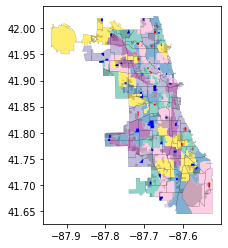

In [23]:
base = plot_assignment(existing_wards_partition.assignment)
base = df[df["Alderperson"].notna() & ~df["Alderperson"].isin(targets)].plot(color=(0,0,1),ax = base)
base = df[df["Alderperson"].notna() & df["Alderperson"].isin(targets)].plot(color=(1,0,0),ax=base)
df[df["incumbent_margin_2019_percentile"] >= .8].plot(color=(0,0,0,.2),ax=base)

In [17]:
partition_list = []
with open("../prec50_20pct_deviation/202012271025.json") as f:
    for line in f:
        partition_list.append(json.loads(line.strip()))

data = pd.read_csv("../prec50_20pct_deviation/results.10000.tsv",sep='\t')

In [21]:
data

Unnamed: 0  step  ward        TOTPOP          HISP      NH_WHITE  \
0                0     0     0  54626.999975  29669.999943  11139.000007   
1                1     0     1  54349.908069  33591.261758  12300.980837   
2                2     0     2  54398.568053   9211.820153  29089.876887   
3                3     0     3  53177.999751   3687.999998  42719.999783   
4                4     0     4  52693.212146  28636.835040   9047.440368   
...            ...   ...   ...           ...           ...           ...   
499995      499995  9999    45  52233.000260   9386.000039  36962.000113   
499996      499996  9999    46  51686.999904  30817.999913   2186.999982   
499997      499997  9999    47  52650.000177  41620.000148   3567.000042   
499998      499998  9999    48  56483.605282  10787.630909  26536.847543   
499999      499999  9999    49  51623.999915  26588.999912  17470.000014   

            NH_BLACK      NH_ASIAN           VAP          HVAP  ...  \
0        7948.000027   5005.999996  42356.999991  20686.999959  ...   
1        6431.722477   1441.945142  39382.547209  22192.473280  ...   
2        8126.551939   6398.629710  47922.018853   6953.951522  ...   
3        2076.999996   3541.999975  49866.999743   3331.999994  ...   
4       14147.939997    419.999600  36683.349763  17961.452684  ...   
...              ...           ...           ...           ...  ...   
499995   2580.000105   2136.999999  43642.000250   7026.000034  ...   
499996  18157.000012    190.000000  34503.999946  19556.999954  ...   
499997   6701.999981    313.000003  36362.000128  27988.000097  ...   
499998   3303.999877  13849.164436  43885.042150   7524.968604  ...   
499999   5746.999996    926.999993  40215.999934  18943.999931  ...   

          100K_125K    125K_150K    150K_200K    200K_MORE  cut_edges  \
0       1371.732839   820.783195   932.065735   870.786713       1255   
1       1497.769495   876.843702   826.409744   417.720362       1255   
2       1653.601999   860.527294  1224.025799  1001.404742       1255   
3       3480.104042  2183.988186  2133.368571  3543.186170       1255   
4       1583.799556  1001.671484   770.671758   296.473492       1255   
...             ...          ...          ...          ...        ...   
499995  2542.410455  1744.500010  2409.698656  4875.453574       1266   
499996   457.945300   362.925896   159.108989    71.890853       1266   
499997   829.306903   586.942752   469.538880   278.151879       1266   
499998  1722.983502   883.004545  1254.616528   971.489381       1266   
499999  1686.243168  1195.313560  1302.282252  1210.131015       1266   

                                     incumbency_advantage  \
0                            {"BYRON SIGCHO-LOPEZ": 0.75}   
1                           {"ARIEL E. REBOYRAS": 0.5625}   
2       {"ANDR\u00c9 VASQUEZ": 0.30769230769230765, "H...   
3                                                      {}   
4                             {"DERRICK G. CURTIS": 0.36}   
...                                                   ...   
499995                                                 {}   
499996                                                 {}   
499997                                                 {}   
499998                                                 {}   
499999          {"ROBERTO MALDONADO": 0.4081632653061224}   

                                              proportions  cohesion  \
0       {"contribution": ["LOWER WEST SIDE", 1.0], "co...  0.380383   
1       {"contribution": ["BELMONT CRAGIN", 0.40278177...  0.380383   
2       {"contribution": ["EDGEWATER", 0.7751402792569...  0.380383   
3       {"contribution": ["LAKE VIEW", 0.4419163166637...  0.380383   
4       {"contribution": ["ASHBURN", 0.767931203951819...  0.380383   
...                                                   ...       ...   
499995  {"contribution": ["NORTH CENTER", 0.4217616585...  0.413695   
499996  {"contribution": ["CHICAGO LAWN", 0.4342839085...  0.413

## Create results CSV

This CSV will have ward-level demographic information for each step of the chain.

In [30]:
data[data["targeted_advantage_mean"] > .58]

step  ward        TOTPOP          HISP      NH_WHITE      NH_BLACK  \
135800  2716     0  51451.999646  12697.000026  21650.999857   4996.999914   
135801  2716     1  54644.578475  16771.934370   5690.968180  31323.685276   
135802  2716     2  51808.999928   8297.000001  17513.000036  11589.999935   
135803  2716     3  54638.617667   5665.641061  44994.983360    568.063629   
135804  2716     4  55245.999973    653.000000    276.000000  53503.999975   
...      ...   ...           ...           ...           ...           ...   
410045  8200    45  53730.999627  11785.999917  31642.999788   6728.999952   
410046  8200    46  55043.999821    546.999999    222.000000  53520.999826   
410047  8200    47  52160.000197  11052.999991  16521.000005  10678.000144   
410048  8200    48  53284.952171  35709.986849   6797.998503   9278.967573   
410049  8200    49  54502.000262  38898.000035  11884.000183   1584.000019   

            NH_ASIAN           VAP          HVAP          WVAP  ...  \
135800  10413.999868  40256.999730   8602.000008  18879.999876  ...   
135801    329.998572  39323.661486  10338.957922   5110.969657  ...   
135802  13214.999962  44413.999930   6181.000007  16128.000033  ...   
135803   2545.618983  43760.169684   3828.642622  36975.177555  ...   
135804     47.999999  42459.999973    422.000000    231.000000  ...   
...              ...           ...           ...           ...  ...   
410045   2383.999975  46308.999683   8971.999941  29160.999806  ...   
410046     36.999999  42133.999877    350.000000    207.999999  ...   
410047  13167.000050  41441.000185   7533.999993  14238.000005  ...   
410048   1040.000012  37453.968970  23342.993387   6043.999267  ...   
410049   1373.000014  39812.000254  26323.000053  10645.000166  ...   

          100K_125K    125K_150K    150K_200K    200K_MORE  cut_edges  \
135800  1737.905924   934.653020  1291.199193  1175.572944       1227   
135801  1537.963666  1042.420151   944.374683   262.157347       1227   
135802  2408.394233  1689.607547  1795.996561  2900.579751       1227   
135803  2349.548626  1409.248850  2131.043278  1839.344049       1227   
135804   932.309611   544.806713   492.407481   241.489418       1227   
...             ...          ...          ...          ...        ...   
410045  2805.625609  1886.853690  2967.333175  4523.896243       1211   
410046  1293.419586   527.643881   522.538503   305.305457       1211   
410047  1351.432930   743.340283   889.200428   615.376628       1211   
410048  1162.546884   587.846289   500.146676   254.362560       1211   
410049  1405.920022   990.004081   993.715159   683.730261       1211   

                                     incumbency_advantage  \
135800         {"ANDR\u00c9 VASQUEZ": 0.5641025641025641}   
135801          {"DERRICK G. CURTIS": 0.7600000000000001}   
135802                                                 {}   
135803  {"ANTHONY V. NAPOLITANO": 0.8510638297872336, ...   
135804                        {"RODERICK T. SAWYER": 0.5}   
...                                                   ...   
410045                      {"WALTER BURNETT, JR.": 0.16}   
410046          {"ANTHONY A. BEALE": 0.47058823529411753}   
410047     {"PATRICK DALEY THOMPSON": 0.7894736842105261}   
410048                                                 {}   
410049       {"CARLOS  RAMIREZ-ROSA": 0.5806451612903225}   

                                              proportions  cohesion  \
135800  {"contribution": ["WEST RIDGE", 0.295946708719...  0.371368   
135801  {"contribution": ["ASHBURN", 0.865689464467028...  0.371368   
135802  {"contribution": ["NEAR SOUTH SIDE", 0.9999999...  0.371368   
135803  {"contribution": ["EDISON PARK", 1.0], "contri...  0.371368   
135804  {"contribution": ["AVALON PARK", 1.0], "contri...  0.371368   
...                                                   ...       ...   
410045  {"contribution": ["WEST TOWN", 0.5782398992488...  0.337778   
410046  {"contribution": ["CHATHAM", 0.7

## Let's hunt for beneficial maps
We've got 12 alders who would CONCEIVABLY go along with this plan. We want to find a plan that:
* puts 10 of them in 10 different wards
* with maximum incumbency advantage... sum? average? median? highest minimum?
Filter to plans where 10 of them are in 10 different wards:
start with mapping (ward) -> (alders), to check an individual plan: for each ward, if at least one of gang of 12 is in ward, increment counter, if counter hits 10 this is such a map. Then, aggregate the incumbency advantage of those alders.

In [ ]:
data.groupby("step").agg(aggregate_advantages)[["ward"]].sort_values(by=["ward"],ascending=False).head(30)

<AxesSubplot:>

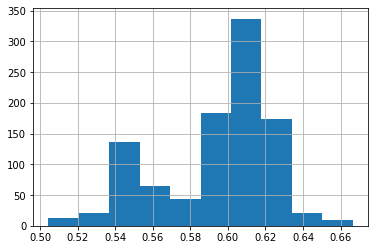

In [27]:
data.groupby("step").min()["two_ward_cohesion"].hist()

<AxesSubplot:>

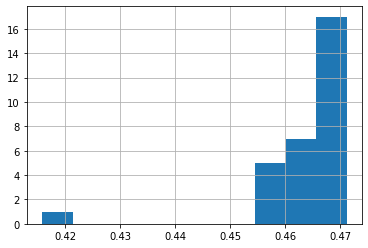

In [32]:
data[data["two_ward_cohesion"] > .64].groupby("step").min()["targeted_advantage_mean"].hist()


In [34]:
data[data["two_ward_cohesion"] > .64]

step  ward        TOTPOP          HISP      NH_WHITE      NH_BLACK  \
43000   860     0  52881.000126  42404.000092   5271.000032   4361.999992   
43001   860     1  54770.999796   3100.999886  39460.999934   2964.999981   
43002   860     2  53686.999826    796.999992   1847.999978  49600.999872   
43003   860     3  52771.588423  20244.831243  27402.757162    745.999999   
43004   860     4  55220.000141  26774.000121  10310.000033  13603.999992   
...     ...   ...           ...           ...           ...           ...   
44495   889    45  52131.999966  44023.999967   4740.999993    547.999998   
44496   889    46  54604.399709   2804.338172  34594.858912  16090.823715   
44497   889    47  55829.441411   4471.439179    720.345796  49651.300992   
44498   889    48  53914.999867   2367.999995  44382.999849   3241.000030   
44499   889    49  56576.999699  26553.000020   2681.999999  26816.999682   

          NH_ASIAN           VAP          HVAP          WVAP  ...  \
43000   347.000006  36979.000085  28631.000050   4755.000029  ...   
43001  7926.999997  51868.999820   2812.999902  37805.999939  ...   
43002   609.999989  37815.999856    551.999993   1673.999979  ...   
43003  3346.000015  40656.493771  13711.736602  23109.757153  ...   
43004  3731.999992  41427.000113  18311.000083   9508.000030  ...   
...            ...           ...           ...           ...  ...   
44495  2583.000009  34605.999972  27862.999976   4190.999994  ...   
44496   314.780332  41233.680351   1716.497824  26586.702560  ...   
44497   114.066996  41809.858241   3059.870072    649.392489  ...   
44498  2864.999994  48221.999900   2028.999998  40500.999881  ...   
44499   154.000000  40949.999800  17495.000008   2569.000000  ...   

         100K_125K    125K_150K    150K_200K    200K_MORE  cut_edges  \
43000   905.843700   684.027274   507.059829   398.086887       1201   
43001  3383.697996  2563.215420  4609.081959  7758.672561       1201   
43002   654.700092   366.886012   257.414876   171.615596       1201   
43003  1690.023769  1250.430046  1313.426047   680.260764       1201   
43004  1428.919677   893.902908   844.317867   971.610584       1201   
...            ...          ...          ...          ...        ...   
44495   635.500757   475.450903   354.587099   208.506952       1191   
44496  2131.983827  1610.622167  2495.213807  1993.321674       1191   
44497  1199.129634   503.222017   407.412610   213.061904       1191   
44498  3380.858017  1978.837583  2761.653308  5391.736911       1191   
44499   511.249770   129.260706   174.214893    69.763129       1191   

                                    incumbency_advantage  \
43000                                                 {}   
43001                                                 {}   
43002          {"JEANETTE B TAYLOR": 0.7179487179487181}   
43003                                                 {}   
43004  {"BYRON SIGCHO-LOPEZ": 0.3125, "WALTER BURNETT...   
...                                                  ...   
44495                                                 {}   
44496          {"MATTHEW J. O'SHEA": 0.9824561403508771}   
44497  {"GREGORY I. MITCHELL": 0.8260869565217388, "M...   
44498  {"MICHELE SMITH": 0.7391304347826084, "TOM TUN...   
44499        {"MICHAEL  SCOTT, JR.": 0.3414634146341463}   

                                             proportions  cohesion  \
43000  {"contribution": ["HERMOSA", 0.534604605620853...  0.358084   
43001  {"contribution": ["NEAR NORTH SIDE", 0.4925170...  0.358084   
43002  {"contribution": ["WOODLAWN", 0.77779822028352...  0.358084   
43003  {"contribution": ["PORTAGE PARK", 0.6444845608...  0.358084   
43004  {"contribution": ["LOWER WEST SIDE", 0.7156474...  0.358084   
...                                                  ...       ...   
44495  {"contribution": ["BRIGHTON PARK", 0.893481947...  0.358084   
44496  {"contribution": ["MOUNT GREENWOOD", 1.0000000...  0.358084   
44497  {"contribution": ["SOUTH CHICA

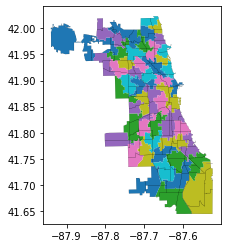

In [37]:
plot_assignment(gc.Partition(precincts,assignment=json.loads(partition_list[889])).assignment)


In [55]:
data[(data["targeted_advantage_mean"] > .5) & (data["cohesion"] > .45)]

step  ward        TOTPOP          HISP      NH_WHITE      NH_BLACK  \
26050    521     0  56015.428682   2792.339222  34146.874695  17922.835557   
26051    521     1  53567.369649   8286.980121  36463.099301    643.364212   
26052    521     2  52360.000015   6410.000005  26953.000012  11554.000000   
26053    521     3  52812.000181  32208.000088  17290.000090    875.000002   
26054    521     4  51456.598697  30229.767069   8841.267671  11569.569668   
...      ...   ...           ...           ...           ...           ...   
477395  9547    45  55797.000474   3374.999915  38872.000488   4281.000023   
477396  9547    46  56327.779916    761.999467    329.994762  54559.795063   
477397  9547    47  52628.000137   7720.000037  38891.000097   1433.000006   
477398  9547    48  55830.864706  25781.952640  19163.418310   2027.000003   
477399  9547    49  55761.999851  29346.999806   5034.000010  20352.000041   

           NH_ASIAN           VAP          HVAP          WVAP  ...  \
26050    312.780332  42376.704947   1707.498725  26238.716244  ...   
26051   6701.261173  41432.893352   5599.796900  29217.398736  ...   
26052   6027.999998  45982.000016   5109.000004  25510.000013  ...   
26053   1824.999999  39169.000125  21648.000057  14995.000068  ...   
26054    366.998523  35950.127888  19065.024252   7882.271058  ...   
...             ...           ...           ...           ...  ...   
477395  7872.000036  52934.000484   3098.999930  37272.000485  ...   
477396    38.999857  41838.916243    474.999470    294.994762  ...   
477397  3257.999994  44301.000111   5872.000030  33471.000081  ...   
477398  7314.547791  42669.025244  17630.250956  16406.137051  ...   
477399   377.999999  39169.999908  19840.999877   4455.000012  ...   

          100K_125K    125K_150K    150K_200K    200K_MORE  cut_edges  \
26050   2174.374118  1605.768418  2442.569602  1924.235511       1200   
26051   2175.976651  1331.294582  2212.938202  2178.029613       1200   
26052   2246.839171  1180.276634  1589.635737  1521.372317       1200   
26053   1153.580826   902.426825   882.767028   543.721130       1200   
26054   1427.690957   970.503832   809.508432   261.482816       1200   
...             ...          ...          ...          ...        ...   
477395  3532.088213  2523.387105  4720.410535  7483.927047       1182   
477396  1322.626778   553.273397   538.174289   296.888860       1182   
477397  2785.996995  2084.842893  2113.680204  4264.875480       1182   
477398  1541.023876   919.635639  1262.271438   967.152627       1182   
477399  1096.264878   594.992781   530.463565   388.727868       1182   

                                     incumbency_advantage  \
26050   {"MATTHEW J. O'SHEA": 0.9473684210526315, "HOW...   
26051   {"SAMANTHA 'SAM' NUGENT": 0.7999999999999997, ...   
26052             {"JAMES CAPPLEMAN": 0.7500000000000001}   
26053   {"ARIEL E. REBOYRAS": 0.3125, "FELIX CARDONA J...   
26054                          {"DERRICK G. CURTIS": 0.2}   
...                                                   ...   
477395                                                 {}   
477396  {"ANTHONY A. BEALE": 0.3529411764705882, "HOWA...   
477397                 {"MATT MARTIN": 0.833333333333333}   
477398       {"R. RODRIGUEZ SANCHEZ": 0.5714285714285713}   
477399            {"JASON C. ERVIN": 0.13043478260869565}   

                                              proportions  cohesion  \
26050   {"contribution": ["MOUNT GREENWOOD", 1.0000000...  0.458254   
26051   {"contribution": ["FOREST GLEN", 1.0], "contri...  0.458254   
26052   {"contribution": ["UPTOWN", 0.7788431909297664...  0.458254   
26053   {"contribution": ["PORTAGE PARK", 0.3968372377...  0.458254   
26054   {"contribution": ["ASHBURN", 0.781442235683874...  0.458254   
...                                                   ...       ...   
477395  {"contribution": ["NEAR NORTH SIDE", 0.4578515...  0.454439   
477396  {"contribution": ["ROSELAND", 0.860441014897

In [60]:
data[data["step"] == 521][(data["HISP"] / data["TOTPOP"] > .5)]

step  ward        TOTPOP          HISP      NH_WHITE      NH_BLACK  \
26053   521     3  52812.000181  32208.000088  17290.000090    875.000002   
26054   521     4  51456.598697  30229.767069   8841.267671  11569.569668   
26057   521     7  52630.000270  27364.000076   3923.000068  18562.000009   
26060   521    10  54568.000047  39849.000110   2475.000017  11520.999916   
26062   521    12  51658.281253  29055.415696   9203.754462  12791.178027   
26063   521    13  53843.999601  44427.999622   4629.999987   1425.000020   
26068   521    18  55331.119237  29100.761951  14646.916676   2516.535726   
26076   521    26  53844.005742  38473.357015   3817.676756  10996.000218   
26085   521    35  55871.000047  31527.000008   9022.999990  11621.000033   
26086   521    36  51341.000013  44242.000013   3602.000004   2268.999991   
26087   521    37  54291.000329  44135.000243   4680.000017   4977.000059   
26089   521    39  55487.000164  31668.000052  18933.000095   1388.000006   
26090   521    40  56308.999771  41104.999832  10860.999951   2958.999993   
26095   521    45  56105.838043  32728.968951  13334.980718   8028.894863   

          NH_ASIAN           VAP          HVAP          WVAP  ...  \
26053  1824.999999  39169.000125  21648.000057  14995.000068  ...   
26054   366.998523  35950.127888  19065.024252   7882.271058  ...   
26057  2284.000116  35166.000212  17098.000053   3365.000062  ...   
26060   244.000000  37468.000031  26722.000070   2232.000015  ...   
26062   122.953209  35579.583860  19157.503232   8207.755304  ...   
26063  3090.999970  36435.999744  28803.999770   4079.999987  ...   
26068  7517.904886  41534.047768  19758.761944  12638.916680  ...   
26076   293.971752  37089.743960  25420.076707   3398.681471  ...   
26085  3123.000010  44199.000032  21798.000010   8531.999991  ...   
26086  1028.000005  33458.000011  27726.000012   3195.000004  ...   
26087   267.000007  35996.000214  27945.000150   4227.000012  ...   
26089  2506.000005  42047.000139  21581.000043  16597.000081  ...   
26090   715.000000  41264.999823  28173.999872   9890.999958  ...   
26095  1370.995661  40670.870981  21493.978420  11583.984367  ...   

         100K_125K    125K_150K    150K_200K    200K_MORE  cut_edges  \
26053  1153.580826   902.426825   882.767028   543.721130       1200   
26054  1427.690957   970.503832   809.508432   261.482816       1200   
26057   647.028296   196.221932   226.322931   154.582066       1200   
26060   836.931299   485.538095   338.570501   280.896862       1200   
26062  1261.773817   360.910730   437.889293   248.335380       1200   
26063   762.248433   416.896162   364.286305   140.761064       1200   
26068  1393.387048   884.662762   987.145971   587.863850       1200   
26076   898.946717   383.938653   268.033878    95.710376       1200   
26085   949.742433   507.693553   628.102574   398.500362       1200   
26086   552.256486   382.953216   245.622662   182.965833       1200   
26087   758.982934   753.654877   259.004656   125.722697       1200   
26089  1540.300677  1013.379766  1190.581093  1064.633849       1200   
26090  1529.456546  1024.991947   928.642078   502.935871       1200   
26095  1507.598971   943.788514   754.436879   509.379308       1200   

                                    incumbency_advantage  \
26053  {"ARIEL E. REBOYRAS": 0.3125, "FELIX CARDONA J...   
26054                         {"DERRICK G. CURTIS": 0.2}   
26057                                                 {}   
26060                                                 {}   
26062      {"SUSAN SADLOWSKI GARZA": 0.8888888888888892}   
26063           {"EDWARD M. BURKE": 0.25806451612903225}   
26068       {"R. RODRIGUEZ SANCHEZ": 0.5714285714285713}   
26076       {"MICHAEL D. RODRIGUEZ": 0.7999999999999999}   
26085                        {"BYRON SIGCHO-LOPEZ": 0.5}   
26086  {"GEORGE CARDENAS": 0.08695652173913043, "RAYM...   
26087                                                 {}   
26089       {"